## Load Libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# distributions
import scipy.integrate as integrate
from scipy.integrate import quad, quad_vec
from scipy.stats import invgamma
from scipy.stats import levy
from scipy.special import gamma, erfinv

import time
from datetime import datetime, timedelta

import sys
import importlib # ref: https://askubuntu.com/questions/144698/find-a-file-by-name-using-command-line
import seaborn as sns

import os

In [3]:
sys.path.append('../tools')
import tools

In [4]:
importlib.reload(tools)

<module 'tools' from '../tools/tools.py'>

## Download Data

In [5]:
df = pd.read_csv('data/apple_cleaned.csv')

## Estimate Spot Volatility

In [6]:
# decide whether you use sample or not
sample = False

if sample:
    data = df[df['date']< '2017-01-30']
    
else:
    data = df.copy()

In [7]:
# Plot style
widths = [1,1,1,1,2]
types = ['solid','dashed','dashdot','dotted', 'dotted']

In [8]:
gs =  [ 0.5, 1, 2, 4]

In [9]:
np.nanmin(data['delta_ts'])

1.0000000000000002e-06

In [16]:
data

,date,ts,date_ts,delta_ts,bin
0,2017-01-03,09:30:00.001271,2017-01-03 09:30:00.001271,NaN,1
1,2017-01-03,09:30:00.046605,2017-01-03 09:30:00.046605,0.045334,1
2,2017-01-03,09:30:00.090184,2017-01-03 09:30:00.090184,0.043579,1
3,2017-01-03,09:30:00.090207,2017-01-03 09:30:00.090207,0.000023,1
4,2017-01-03,09:30:00.090214,2017-01-03 09:30:00.090214,0.000007,1
...,...,...,...,...,...
36247420,2017-12-29,15:59:59.928277,2017-12-29 15:59:59.928277,0.004484,13
36247421,2017-12-29,15:59:59.929634,2017-12-29 15:59:59.929634,0.001357,13
36247422,2017-12-29,15:59:59.940988,2017-12-29 15:59:59.940988,0.011354,13
36247423,2017-12-29,15:59:59.952536,2017-12-29 15:59:59.952536,0.011548,13


### By bins

#### Wide 0

In [10]:
ts = np.geomspace(0.0000001, 10, num = 100)


#### Pdf and Cdf

In [11]:
##### check the for loop, is it actually doing what it is supposed to d
sigma_hats_ts = []
f_hats_ts = []
F_hats_ts= []

constant = 400
n = np.shape(data)[0]
delta = (np.sqrt(n)/2)*constant
#a_n = (2/3)*delta


# subset the dataframe
t_g_ws = np.array(data['delta_ts']) 

    
# for each t
for (t, i) in zip(ts, range(0, len(ts))):
    

    
    # start_time for current iteration
    start_time = time.time()
    

    # calculate f_hat
    f_hat = tools.f_hat_t(t, t_g_ws, delta)

    # calculate F_hat
    F_hat = tools.F_hat_t(t, t_g_ws, delta)
           
    
    # store the estimates
    f_hats_ts.append(f_hat)
    F_hats_ts.append(F_hat)

    # show the end time
    end_time = time.time()  
    
    
    if i in [0,1, 10, 100, 500, 750, 1000, 5000, 10000]:
        print(f"Time : {end_time - start_time} for t = {t} for i = {i}")

Time : 24.438105821609497 for t = 1e-07 for i = 0
Time : 21.122777700424194 for t = 1.204503540258781e-07 for i = 1
Time : 19.625168800354004 for t = 6.428073117284319e-07 for i = 10


#### Spot Volatility and Standard Deviation

In [12]:
a_n = (8*(n)**(0.2))/(max(ts) - min(ts))

In [13]:
sigma_hats_gs = []
std_gs = []

for g_i, g in zip(range(0, len(gs)), gs):
    
    sigma_hats_ts = []
    std_ts = []
    
    # for each t
    for i, t in zip(range(0, len(ts)),ts):
        
        sigma_hats_t = tools.sigma_hat_t(f_hats_ts[i],  F_hats_ts[i], g)[0]
        sigma_hats_ts.append(sigma_hats_t)
        
        # calculate standard deviation
        std = np.sqrt((n/a_n)*(tools.fgW( tools.PgW_inv(F_hats_ts[i], g), g)/f_hats_ts[i]))**(-1)
        std_ts.append(std)
    
    sigma_hats_gs.append(sigma_hats_ts)
    std_gs.append(std_ts)
    
    

<ipython-input-13-1b4439d2480e>:16: RuntimeWarning: divide by zero encountered in double_scalars
  std = np.sqrt((n/a_n)*(tools.fgW( tools.PgW_inv(F_hats_ts[i], g), g)/f_hats_ts[i]))**(-1)


#### Summary Stats

In [14]:
summary_stats = [np.nanmean]

# list to store summaries
summaries = []

# for each t
for i, t in zip(range(0, len(ts)),ts):
    
    
    # calculate summary stats
    f_stats = tools.estimation_summary(f_hats_ts[i], summary_stats, rounding = 10)
    F_stats = tools.estimation_summary(F_hats_ts[i], summary_stats, rounding = 10)
    # create a dataframe
    summary_t = pd.DataFrame([f_stats, F_stats],columns =  ['Mean'],
                            index = [np.tile(t, 2) , ['$\widehat{f}$', '$\widehat{F}$']])
    
    summary_t.index.set_names(['t', 'Statistics'], inplace = True)
    
    # store the summary
    summaries.append(summary_t)

    


In [15]:
pd.concat(summaries)

Mean
t            Statistics                 
1.000000e-07 $\widehat{f}$  0.000000e+00
             $\widehat{F}$  2.760000e-08
1.204504e-07 $\widehat{f}$  0.000000e+00
             $\widehat{F}$  2.760000e-08
1.450829e-07 $\widehat{f}$  0.000000e+00
...                                  ...
6.892612e+00 $\widehat{F}$  9.999094e-01
8.302176e+00 $\widehat{f}$  0.000000e+00
             $\widehat{F}$  9.999659e-01
1.000000e+01 $\widehat{f}$  0.000000e+00
             $\widehat{F}$  9.999850e-01

[200 rows x 1 columns]

In [472]:
# prepare the final table
pd_distribution_summary = pd.concat(summaries).reset_index()
sample_rows = pd_distribution_summary['t'].sample(frac = 0.1)

In [509]:
sample_rows = pd_distribution_summary[pd_distribution_summary['t']<2.0] # .sample(frac = 0.2)

In [510]:
print(pd_distribution_summary[pd_distribution_summary['t'].isin(sample_rows['t'].values) ].to_latex( caption = 'Estimated pdf and cdf of the first-hitting times in seconds for Apple in 2017 and several t',
                        #float_format="%.2f",
                        formatters = {'Mean': "{:.2E}".format,
#                                       'Median': "{:.2E}".format,
#                                       'Std': "{:.2E}".format,
#                                       '5.0%': "{:.2E}".format,
#                                       '95%': "{:.2E}".format
                                     },
                        position = 'H',
                        longtable = True,
                        escape=False))

\begin{longtable}[H]{lrlr}
\caption{Estimated pdf and cdf of the first-hitting times in seconds for Apple in 2017 and several t}\\
\toprule
{} &             t &     Statistics &     Mean \\
\midrule
\endfirsthead
\caption[]{Estimated pdf and cdf of the first-hitting times in seconds for Apple in 2017 and several t} \\
\toprule
{} &             t &     Statistics &     Mean \\
\midrule
\endhead
\midrule
\multicolumn{4}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
0   &  1.000000e-07 &  $\widehat{f}$ & 0.00E+00 \\
1   &  1.000000e-07 &  $\widehat{F}$ & 2.76E-08 \\
2   &  1.204504e-07 &  $\widehat{f}$ & 0.00E+00 \\
3   &  1.204504e-07 &  $\widehat{F}$ & 2.76E-08 \\
4   &  1.450829e-07 &  $\widehat{f}$ & 0.00E+00 \\
5   &  1.450829e-07 &  $\widehat{F}$ & 2.76E-08 \\
6   &  1.747528e-07 &  $\widehat{f}$ & 8.86E+01 \\
7   &  1.747528e-07 &  $\widehat{F}$ & 2.60E-07 \\
8   &  2.104904e-07 &  $\widehat{f}$ & 6.93E+02 \\
9   &  2.104904e-07 &  $\widehat{F}$ & 1.42

<ipython-input-510-d0317b84c23a>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd_distribution_summary[pd_distribution_summary['t'].isin(sample_rows['t'].values) ].to_latex( caption = 'Estimated pdf and cdf of the first-hitting times in seconds for Apple in 2017 and several t',


In [377]:
summary_stats = [np.nanmean, np.nanmedian, np.nanstd, 0.05, 0.95]
summaries = []

# Initialize gs, ts, and sigma_hats_gs variables with appropriate values

# Iterate over groups
for g_i, g in enumerate(gs):
    sigma_hats_g = sigma_hats_gs[g_i]

    # Iterate over time periods
    for i, t in enumerate(ts):
        sigma_hats = sigma_hats_g[i]

        # Calculate summary statistics
        sigma_hats_stats = tools.estimation_summary(sigma_hats, summary_stats, rounding=10)

        # Create a dataframe
        summary_t = pd.DataFrame([sigma_hats_stats],
                                 columns=['Mean', 'Median', 'Std', '5.0%', '95%'],
                                 index=pd.MultiIndex.from_tuples([(g, t, '$\widehat{\sigma}_{t}$')],
                                                                 names=['g', 't', 'Statistics']))

        summaries.append(summary_t)

In [378]:
pd.concat(summaries)

Mean        Median  Std  \
g   t            Statistics                                                
0.5 1.000000e-07 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   
    1.204504e-07 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   
    1.450829e-07 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   
    1.747528e-07 $\widehat{\sigma}_{t}$  2.342026e+05  2.342026e+05  0.0   
    2.104904e-07 $\widehat{\sigma}_{t}$  6.545830e+04  6.545830e+04  0.0   
...                                               ...           ...  ...   
4.0 4.750810e+00 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   
    5.722368e+00 $\widehat{\sigma}_{t}$  2.580146e+10  2.580146e+10  0.0   
    6.892612e+00 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   
    8.302176e+00 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   
    1.000000e+01 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  0.0   

                                                 5.0%           95%  
g   t            Statistics                                          
0.5 1.000000e-07 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  
    1.204504e-07 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  
    1.450829e-07 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  
    1.747528e-07 $\widehat{\sigma}_{t}$  2.342026e+05  2.342026e+05  
    2.104904e-07 $\widehat{\sigma}_{t}$  6.545830e+04  6.545830e+04  
...                                               ...           ...  
4.0 4.750810e+00 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  
    5.722368e+00 $\widehat{\sigma}_{t}$  2.580146e+10  2.580146e+10  
    6.892612e+00 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  
    8.302176e+00 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  
    1.000000e+01 $\widehat{\sigma}_{t}$  0.000000e+00  0.000000e+00  

[400 rows x 5 columns]

In [420]:
pd_sigma_summary = pd.concat(summaries).reset_index()

In [431]:
print(pd_sigma_summary[pd_sigma_summary['t']<2].to_latex( caption = 'Summary statistics of Empirical Estimate of Volatility with different g',
                        float_format="%.2f",
                        formatters = {'Mean': "{:.2E}".format,
                                      'Median': "{:.2E}".format,
                                      #'Bias': "{:.2E}".format,
                                      'Std': "{:.2E}".format,
                                      '5.0%': "{:.2E}".format,
                                      '95%': "{:.2E}".format},
                        position = 'H',
                        longtable = True,
                        escape=False))

\begin{longtable}[H]{lrrlrrrrr}
\caption{Summary statistics of Empirical Estimate of Volatility with different g}\\
\toprule
{} &    g &    t &              Statistics &     Mean &   Median &      Std &     5.0% &      95% \\
\midrule
\endfirsthead
\caption[]{Summary statistics of Empirical Estimate of Volatility with different g} \\
\toprule
{} &    g &    t &              Statistics &     Mean &   Median &      Std &     5.0% &      95% \\
\midrule
\endhead
\midrule
\multicolumn{9}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
0   & 0.50 & 0.00 &  $\widehat{\sigma}_{t}$ & 0.00E+00 & 0.00E+00 & 0.00E+00 & 0.00E+00 & 0.00E+00 \\
1   & 0.50 & 0.00 &  $\widehat{\sigma}_{t}$ & 0.00E+00 & 0.00E+00 & 0.00E+00 & 0.00E+00 & 0.00E+00 \\
2   & 0.50 & 0.00 &  $\widehat{\sigma}_{t}$ & 0.00E+00 & 0.00E+00 & 0.00E+00 & 0.00E+00 & 0.00E+00 \\
3   & 0.50 & 0.00 &  $\widehat{\sigma}_{t}$ & 2.34E+05 & 2.34E+05 & 0.00E+00 & 2.34E+05 & 2.34E+05 \\
4   & 0.50 & 0.00 &  $\wide

<ipython-input-431-aa3a66ee3df3>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd_sigma_summary[pd_sigma_summary['t']<2].to_latex( caption = 'Summary statistics of Empirical Estimate of Volatility with different g',


#### Plots

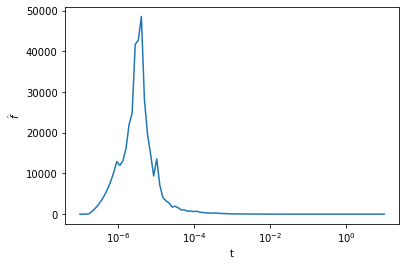

In [455]:
plt.plot(ts,
        f_hats_ts #/np.sum(f_hats_ts),
        #label = f'$\delta$ = '+'$\sqrt{n}$/2'+"$\cdot$"+f'{constant}'
        )
plt.ylabel('$\widehat{f}$')
plt.xlabel('t')

plt.xscale('log')
#plt.legend()

plt.savefig('figures/distributions/pdf', facecolor='w',
            dpi=1000,bbox_inches='tight')

plt.show()

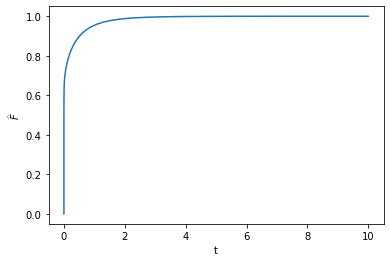

In [453]:
plt.plot(ts, F_hats_ts,
        #label = f'$\delta$ = '+'$\sqrt{n}$/2'+"$\cdot$"+f'{constant}'
        )
plt.ylabel('$\widehat{F}$')
plt.xlabel('t')
#plt.xscale('log')
#plt.legend()

plt.savefig('figures/distributions/cdf', facecolor='w',
            dpi=1000)
plt.show()
plt.close()

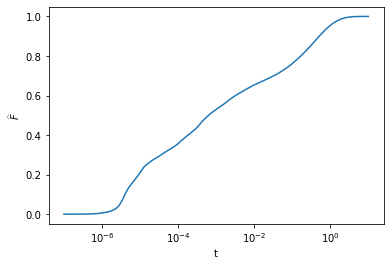

In [454]:
plt.plot(ts, F_hats_ts)
plt.ylabel('$\widehat{F}$')
plt.xlabel('t')
plt.xscale('log')
#plt.yscale('log')
#plt.legend()

plt.savefig('figures/distributions/cdf_log', facecolor='w',
            dpi=1000)
plt.show()
plt.close()

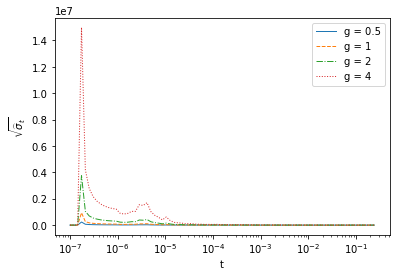

In [520]:
for g_i in range(0, len(gs)):
    plt.plot(ts[0:80], sigma_hats_gs[g_i][0:80],
            label = f'g = {gs[g_i]}',
            linestyle = types[g_i],
            linewidth = widths[g_i])
     
plt.xscale('log')
#plt.yscale('log')
plt.ylabel('$\sqrt{\widehat{\sigma}_{t}}$')
plt.xlabel('t')
plt.legend()

plt.savefig('figures/distributions/sigma', facecolor='w',
            dpi=1000)  
plt.show()
plt.close()

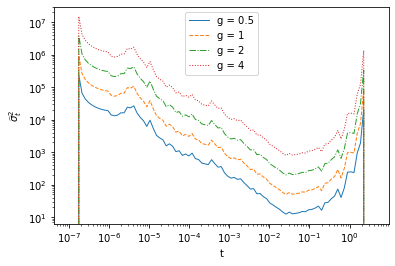

In [531]:
for g_i in range(0, len(gs)):
    plt.plot(ts[0:95], sigma_hats_gs[g_i][0:95],
            label = f'g = {gs[g_i]}',
            linestyle = types[g_i],
            linewidth = widths[g_i])
     
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\widehat{\sigma}_{t}^2$')
plt.xlabel('t')
plt.legend()

plt.savefig('figures/distributions/sigma_logged', facecolor='w',
            dpi=1000)  
plt.show()
plt.close()

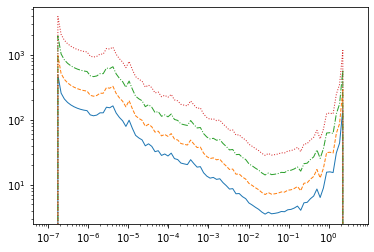

In [538]:
for g_i in range(0, len(gs)):
    plt.plot(ts[0:95], np.sqrt(sigma_hats_gs[g_i][0:95]),
            label = f'g = {gs[g_i]}',
            linestyle = types[g_i],
            linewidth = widths[g_i])
    
plt.xscale('log')
plt.yscale('log')

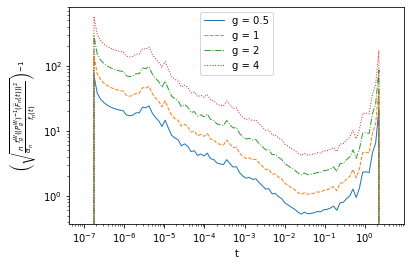

In [554]:
for g_i in range(0, len(gs)):
    plt.plot(ts[0:95], std_gs[g_i][0:95],
            label = f'g = {gs[g_i]}',
            linestyle = types[g_i],
            linewidth = widths[g_i])
     
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\left(\sqrt{\frac{n}{\alpha_n} \frac{f_g^W((P_g^W)^{-1}(\widehat{F}_n(t)))^2}{\widehat{f}_n(t)}}\right)^{-1}$')
plt.xlabel('t')
plt.legend()

plt.savefig('figures/distributions/sigma_std_logged', facecolor='w',
            dpi=1000)  
plt.show()
plt.close()